In [1]:
import hashlib
import os
import tarfile
import zipfile
import requests

#@save
DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

In [2]:
def download(name, cache_dir=os.path.join('..', 'data')):  #@save
    """下载一个DATA_HUB中的文件，返回本地文件名"""
    assert name in DATA_HUB, f"{name} 不存在于 {DATA_HUB}"
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname  # 命中缓存
    print(f'正在从{url}下载{fname}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

In [3]:
def download_extract(name, folder=None):  #@save
    """下载并解压zip/tar文件"""
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext in ('.tar', '.gz'):
        fp = tarfile.open(fname, 'r')
    else:
        assert False, '只有zip/tar文件可以被解压缩'
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir

def download_all():  #@save
    """下载DATA_HUB中的所有文件"""
    for name in DATA_HUB:
        download(name)

## 1. Read the data

In [4]:
%matplotlib inline
import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l
from torch.utils.data import Dataset, DataLoader

In [5]:
DATA_HUB['kaggle_house_train'] = (  #@save
    DATA_URL + 'kaggle_house_pred_train.csv',
    '585e9cc93e70b39160e7921475f9bcd7d31219ce')

DATA_HUB['kaggle_house_test'] = (  #@save
    DATA_URL + 'kaggle_house_pred_test.csv',
    'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')

In [6]:
train_data = pd.read_csv(download('kaggle_house_train'))
test_data = pd.read_csv(download('kaggle_house_test'))

In [7]:
print(f'The shape of training data is {train_data.shape}\nThe shape of testing data is {test_data.shape}')

The shape of training data is (1460, 81)
The shape of testing data is (1459, 80)


In [8]:
# visualize some of the data and their features
print(train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]])

   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000


In [9]:
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))
all_features.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


## 2. Data Preprocessing

In [10]:
# replace all the numeric nan value with feature mean and do standardization
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(lambda x: (x - x.mean())/ (x.std()))

all_features[numeric_features] = all_features[numeric_features].fillna(0)

In [11]:
# `Dummy_na=True` considers "na" (missing value) as a valid feature value, and
# creates an indicator feature for it
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape

(2919, 331)

In [12]:
# get dummies increase the number of features to 331
all_features.columns.unique()

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       ...
       'SaleType_Oth', 'SaleType_WD', 'SaleType_nan', 'SaleCondition_Abnorml',
       'SaleCondition_AdjLand', 'SaleCondition_Alloca', 'SaleCondition_Family',
       'SaleCondition_Normal', 'SaleCondition_Partial', 'SaleCondition_nan'],
      dtype='object', length=331)

## 3. Training

In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [14]:
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[: n_train].values, dtype = torch.float32, device=device)
test_features = torch.tensor(all_features[n_train: ].values, dtype = torch.float32, device=device)
train_labels = torch.tensor(
    train_data['SalePrice'].values.reshape(-1, 1), dtype = torch.float32, device=device
)

In [15]:
# get the data
batch_size = 64
class Train(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels
    
    def __getitem__(self, idx):
        feature = self.features[idx]
        label = self.labels[idx]
        return feature, label
    
    def __len__(self):
        return len(self.features)

In [16]:
loss = nn.MSELoss()
# Define the loss function
def log_rmse(preds, y):
    clipped_preds = torch.clamp(preds, 1, float('inf'))
    rmse = torch.sqrt(loss(torch.log(clipped_preds), torch.log(y)))
    return rmse.item()

In [17]:
def train(num_epochs, net, train_features, train_labels, test_features, test_labels, batch_size, loss, optimizer, silent = True):
    train_ls, test_ls = [], []
    # get the training data iterator
    train_iter = DataLoader(Train(train_features, train_labels), batch_size=batch_size, shuffle=True)
    
    for epoch in range(num_epochs):
        for X, y in train_iter:
            X, y = X.to(device), y.to(device)
            l = loss(net(X), y)
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net(train_features), train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net(test_features), test_labels))

        if not silent:
            if (epoch + 1) % 10 == 0:
                print(f'After {epoch + 1} epochs, the log rmse is {train_ls[-1]}')
    
    return train_ls, test_ls

In [18]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

def k_fold(k, num_epochs, X_train, y_train, batch_size, loss, lr, wd):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        net = get_net().to(device)
        optimizer = torch.optim.Adam(params=net.parameters(), lr=lr, weight_decay=wd)
        data = get_k_fold_data(k, i, X_train, y_train) 
        train_ls, valid_ls = train(num_epochs, net, *data, batch_size, loss, optimizer)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]

        print(f'Fold {i + 1}, training log rmse {float(train_ls[-1]):f}, '
              f'validating log rmse {float(valid_ls[-1]):f}')

    d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
            xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
            legend=['train', 'valid'], yscale='log')
    
    return train_l_sum / k, valid_l_sum / k

In [19]:
# Define the number of folds
k = 5
# Define the number of epochs to train
num_epochs = 1000
# Define the batch size
batch_size = 256

In [20]:
# Define a simple linear model
in_features = train_features.shape[1]
# in every k-fold we need a new model so we cannot use net as a parameter of the function
def get_net():
    net = nn.Sequential(nn.Linear(in_features, 1))
    return net

In [21]:
# Define the optimizer
wd = 0
lr = 5

Fold 1, training log rmse 0.131429, validating log rmse 0.146273
Fold 2, training log rmse 0.128950, validating log rmse 0.148756
Fold 3, training log rmse 0.127556, validating log rmse 0.141695
Fold 4, training log rmse 0.133001, validating log rmse 0.138703
Fold 5, training log rmse 0.125345, validating log rmse 0.169599


(0.12925630807876587, 0.14900541305541992)

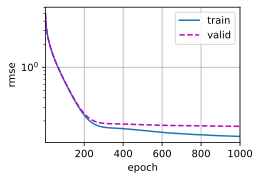

In [22]:
k_fold(k, num_epochs, train_features, train_labels, batch_size, loss, lr, wd)

## 4. More complex neural networks

In [23]:
class NeuralNetwork(nn.Module):
    def __init__(self, num_inputs, num_outputs, num_hidden1, num_hidden2):
        super().__init__()
        self.num_inputs = num_inputs
        self.lin_relu_stack = nn.Sequential(
            nn.Linear(num_inputs, num_hidden1),
            nn.ReLU(),
            nn.Linear(num_hidden1, num_hidden2),
            nn.ReLU(),
            nn.Linear(num_hidden2, num_outputs),
        )
    
    def forward(self, X):
        out = self.lin_relu_stack(X)

        return out

num_inputs, num_outputs, num_hidden1, num_hidden2 = train_features.shape[1], 1, 256, 256

def get_net():  
    net = NeuralNetwork(num_inputs, num_outputs, num_hidden1, num_hidden2)

    def init_weights(m):
        if type(m) == nn.Linear:
            m.weight.data.normal_(0, 0.01)
    
    net.apply(init_weights)
    return net

Fold 1, training log rmse 0.072477, validating log rmse 0.147441
Fold 2, training log rmse 0.065790, validating log rmse 0.155590
Fold 3, training log rmse 0.056760, validating log rmse 0.149974
Fold 4, training log rmse 0.076194, validating log rmse 0.115770
Fold 5, training log rmse 0.064228, validating log rmse 0.155159


(0.06708980351686478, 0.14478669911623002)

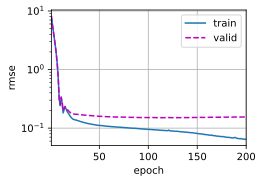

In [24]:
lr = 0.01
wd = 2
k_fold(k, 200, train_features, train_labels, batch_size, loss, lr, wd)

## Train and predict

In [25]:
num_epochs = 300
net = NeuralNetwork(num_inputs, num_outputs, num_hidden1, num_hidden2).to(device)
batch_size = 256

lr = 0.01
wd = 2
optimizer = torch.optim.Adam(net.parameters(), lr = lr, weight_decay = wd)

In [26]:
train_loss, _ = train(num_epochs, net, train_features, train_labels, None, None, batch_size, loss, optimizer, False)

After 10 epochs, the log rmse is 0.189472958445549
After 20 epochs, the log rmse is 0.14545348286628723
After 30 epochs, the log rmse is 0.13227680325508118
After 40 epochs, the log rmse is 0.12373784184455872
After 50 epochs, the log rmse is 0.11904310435056686
After 60 epochs, the log rmse is 0.11694122850894928
After 70 epochs, the log rmse is 0.11462794244289398
After 80 epochs, the log rmse is 0.11325860023498535
After 90 epochs, the log rmse is 0.11149123311042786
After 100 epochs, the log rmse is 0.10947088152170181
After 110 epochs, the log rmse is 0.10782059282064438
After 120 epochs, the log rmse is 0.1069975271821022
After 130 epochs, the log rmse is 0.1048164963722229
After 140 epochs, the log rmse is 0.10322178155183792
After 150 epochs, the log rmse is 0.10166707634925842
After 160 epochs, the log rmse is 0.10017203539609909
After 170 epochs, the log rmse is 0.09806357324123383
After 180 epochs, the log rmse is 0.09719382971525192
After 190 epochs, the log rmse is 0.09465

In [27]:
def pred(net, test_features, test_data):
    result = net(test_features).detach()
    if device != 'cpu':
        result = result.cpu()
    test_data['SalePrice'] = result.numpy()
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)

pred(net, test_features, test_data)

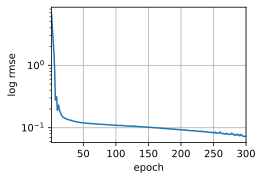

In [28]:
d2l.plot(np.arange(1, num_epochs + 1), [train_loss], xlabel='epoch',
            ylabel='log rmse', xlim=[1, num_epochs], yscale='log')